In [58]:
import numpy as np
import os
from scipy.constants import mu_0, epsilon_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
import geoana.em.fdem as fdem
from geoana import utils, spatial

from scipy import optimize

In [2]:
def plot_amplitude(x, z, v, ax, vmin=None, vmax=None):
    v = spatial.vector_magnitude(v)
    plt.colorbar(
        ax.pcolormesh(
            x, z, v.reshape(len(x), len(z), order='F').T, norm=LogNorm(vmin=vmin, vmax=vmax)
        ), ax=ax
    )
    ax.axis('square')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    ax.set_aspect(1)


# plot streamlines
def plot_streamlines(x, z, v, ax):
    vx = v[:, 0].reshape(len(x), len(z), order='F')
    vz = v[:, 2].reshape(len(x), len(z), order='F')
    ax.streamplot(x, z, vx.T, vz.T, color='k')

In [577]:
mur = 1
sigma = 5e6
dc_dipole = fdem.ElectricDipoleWholeSpace(sigma=sigma, mu=mur*mu_0, frequency=0, orientation = "z")

In [578]:
rx_x = 0.25 * np.linspace(-1, 1, 500)
rx_locs = utils.ndgrid(rx_x, np.r_[0], rx_x)

In [579]:
def skin_depth(freq, sig=sigma, mur=mur):
    return 1/np.sqrt(np.pi * freq * sig * mur * mu_0)

In [580]:
dc_currents = dc_dipole.current_density(rx_locs)

frequencies = 10**np.linspace(-1, 4, 36)

In [581]:
freq_ind = 28
dipole = fdem.ElectricDipoleWholeSpace(sigma=sigma, mu=mur*mu_0, frequency=frequencies[freq_ind], orientation = "z")
total = dipole.current_density(rx_locs)

In [582]:
def draw_circle(r, ax=None, color="w"):
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    x = np.linspace(-r, r, 100)
    y = np.sqrt(r**2 - x**2) 
    ax.plot(x, y, color=color)
    ax.plot(x, -y, color=color)
    

Text(0.5, 0.98, '5e+06 S/m, 1$\\mu_0$, 1.0e+03 Hz, skin depth: 7.1e-03 m')

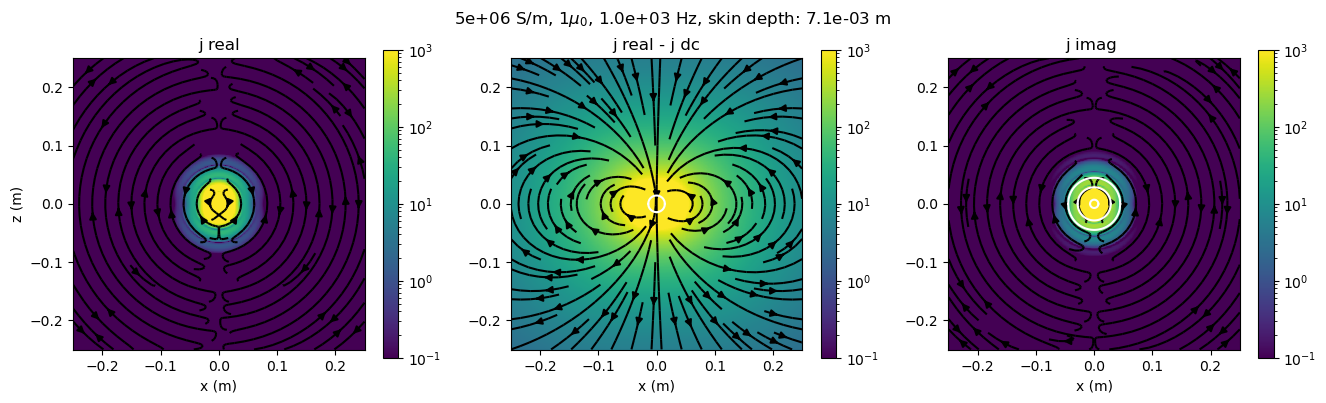

In [583]:
vmin = 1e-1
vmax = 1e3
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

plot_amplitude(rx_x, rx_x, total.real, ax[0], vmin=vmin, vmax=vmax)
plot_streamlines(rx_x, rx_x, total.real, ax[0])
ax[0].set_title(f"j real")
# draw_circle(np.pi*skin_depth(frequencies[freq_ind]), ax=ax[0])

plot_amplitude(rx_x, rx_x, total.real - dc_currents.real, ax[1], vmin=vmin, vmax=vmax)
plot_streamlines(rx_x, rx_x, total.real - dc_currents.real, ax[1])
ax[1].set_title(f"j real - j dc")
draw_circle(2*skin_depth(frequencies[freq_ind]), ax=ax[1])

plot_amplitude(rx_x, rx_x, total.imag, ax[2], vmin=vmin, vmax=vmax)
plot_streamlines(rx_x, rx_x, total.imag, ax[2])
ax[2].set_title(f"j imag ")

draw_circle(skin_depth(frequencies[freq_ind]), ax=ax[2])
draw_circle(4*skin_depth(frequencies[freq_ind]), ax=ax[2])
draw_circle(2*np.pi*skin_depth(frequencies[freq_ind]), ax=ax[2])

for i, a in enumerate(ax): 
    if i > 0: 
        a.set_ylabel(None)
    


fig.suptitle(f"{sig:1.0e} S/m, {mur:1.0f}$\mu_0$, {frequencies[freq_ind]:1.1e} Hz, skin depth: {skin_depth(frequencies[freq_ind]):1.1e} m")

In [584]:
b_field = dipole.magnetic_flux_density(rx_locs)

b0_field = dc_dipole.magnetic_flux_density(rx_locs)

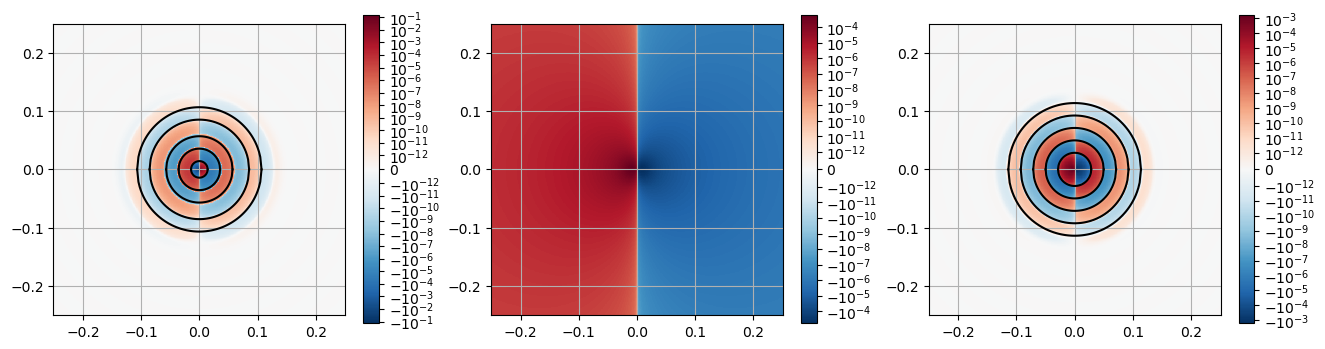

In [585]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

vmin=1e-12
# vmax=1e0

plt.colorbar(ax[0].pcolormesh(
    rx_x, rx_x, 
    (b_field[:, 1].real.reshape(len(rx_x), len(rx_x), order='F')).T, 
    norm=SymLogNorm(linthresh=vmin), 
    cmap="RdBu_r"
), ax=ax[0])
draw_circle(2*skin_depth(frequencies[freq_ind]), ax=ax[0], color="k")
draw_circle(5*skin_depth(frequencies[freq_ind]), ax=ax[0], color="k")
draw_circle(8*skin_depth(frequencies[freq_ind]), ax=ax[0], color="k")
draw_circle(12*skin_depth(frequencies[freq_ind]), ax=ax[0], color="k")
draw_circle(15*skin_depth(frequencies[freq_ind]), ax=ax[0], color="k")

plt.colorbar(ax[1].pcolormesh(
    rx_x, rx_x, 
    ((b_field[:, 1] - b0_field[:, 1]).real.reshape(len(rx_x), len(rx_x), order='F')).T, 
    norm=SymLogNorm(linthresh=vmin), 
    cmap="RdBu_r"
), ax=ax[1])

plt.colorbar(ax[2].pcolormesh(
    rx_x, rx_x, 
    (b_field[:, 1].imag.reshape(len(rx_x), len(rx_x), order='F')).T, 
    norm=SymLogNorm(linthresh=vmin), 
    cmap="RdBu_r"
), ax=ax[2])
draw_circle(4*skin_depth(frequencies[freq_ind]), ax=ax[2], color="k")
draw_circle(7*skin_depth(frequencies[freq_ind]), ax=ax[2], color="k")
draw_circle(10*skin_depth(frequencies[freq_ind]), ax=ax[2], color="k")
draw_circle(13*skin_depth(frequencies[freq_ind]), ax=ax[2], color="k")
draw_circle(16*skin_depth(frequencies[freq_ind]), ax=ax[2], color="k")

for a in ax.flatten():
    a.set_aspect(1)
    a.grid()

In [592]:
# look at amplitude of jreal - jdc, breal - bdc as a function of frequency
frequencies = 10**np.linspace(-4, 5, 5000)

rx_loc = np.r_[0.1, 0, 0]

j = np.zeros_like(frequencies, dtype=np.complex128)
b = np.zeros_like(frequencies, dtype=np.complex128) 

j_real_minus_dc = np.zeros_like(frequencies)
b_real_minus_dc = np.zeros_like(frequencies)

j_dc = dc_dipole.current_density(rx_loc)[2].real
b_dc = dc_dipole.magnetic_flux_density(rx_loc)[1].real


for i, f in enumerate(frequencies): 
    dipole.frequency = f
    j[i] = dipole.current_density(rx_loc)[2]
    b[i] = dipole.magnetic_flux_density(rx_loc)[1]
    
    j_real_minus_dc[i] = j[i].real - j_dc
    b_real_minus_dc[i] = b[i].real - b_dc


In [593]:
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# ax[0].semilogx(frequencies, (j.real-j_dc)/np.abs(j_dc), label="real")
# ax[0].semilogx(frequencies, j.imag/np.abs(j_dc), label="imag")

# ax[1].semilogx(frequencies, (b.real-b_dc)/np.abs(b_dc))
# ax[1].semilogx(frequencies, b.imag/np.abs(b_dc))

# for a in ax.flatten():
#     a.grid()
#     # a.set_xlim(np.r_[1e-1, 1e3])

# ax[0].legend()
# ax[0].set_title("(a) (j(freq) - j$_{dc}$) / |j$_{dc}$|")
# ax[1].set_title("(b) (b(freq) - b$_{dc}$) / |b$_{dc}$|")
# ax[1].set_xlabel("frequency (Hz)")

# fig.suptitle(f"{sigma:1.1e} S/m, {mur} $\mu_0$, x={rx_loc[0]}m ")
# plt.tight_layout()

In [594]:
delta = skin_depth(frequencies)
x_axis = rx_loc[0]/delta # / delta

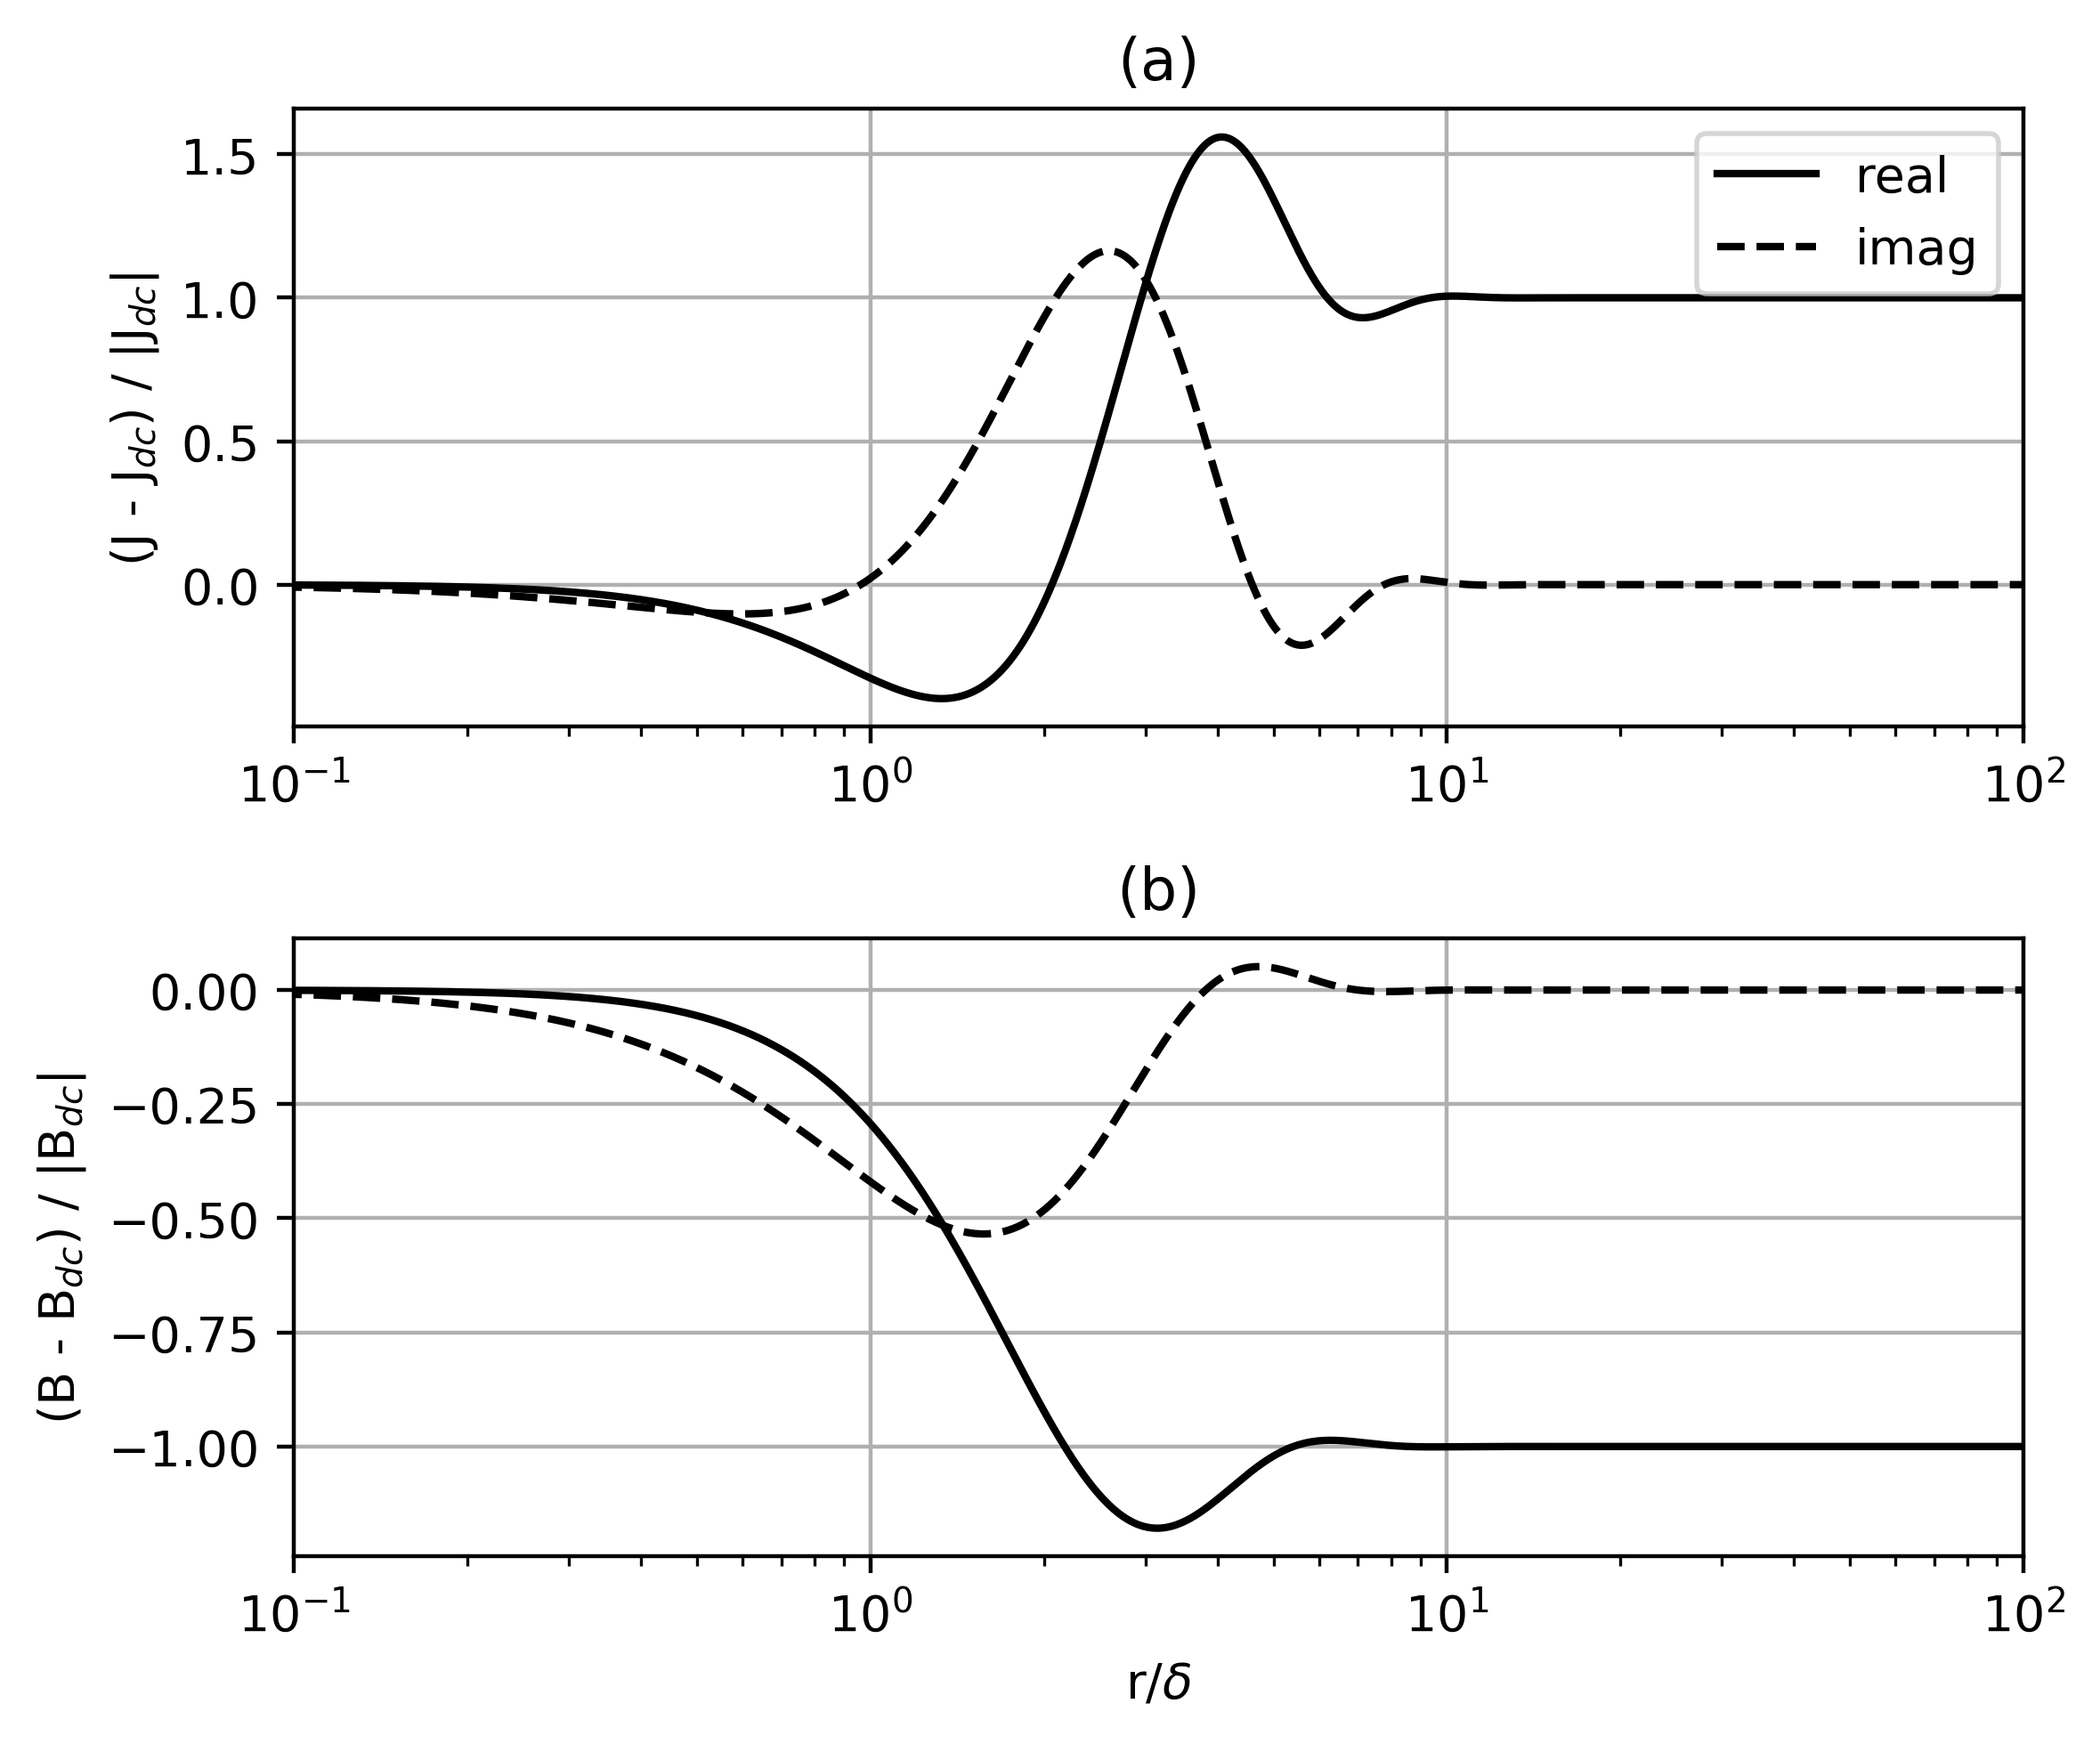

In [600]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5), dpi=400)

ax[0].semilogx(x_axis, (j.real-j_dc)/np.abs(j_dc), "k", label="real")
ax[0].semilogx(x_axis, j.imag/np.abs(j_dc), "--k", label="imag")

ax[1].semilogx(x_axis, (b.real-b_dc)/np.abs(b_dc), "k")
ax[1].semilogx(x_axis, b.imag/np.abs(b_dc), "--k")

for a in ax.flatten():
    a.grid()
    a.set_xlim(np.r_[1e-1, 1e2])

ax[0].set_ylabel("(J - J$_{dc}$) / |J$_{dc}|$")
ax[1].set_ylabel("(B - B$_{dc}$) / |B$_{dc}|$")

ax[0].legend()
ax[0].set_title("(a)")
ax[1].set_title("(b)")
ax[1].set_xlabel("r/$\delta$")
# fig.suptitle(f"{sigma:1.1e} S/m, {mur} $\mu_0$, x={rx_loc[0]}m ")
plt.tight_layout()

In [167]:
rx_line_x = 0.2*np.linspace(-1, 1, 500)

rx_line_locs = utils.ndgrid(rx_line_x, np.r_[0], np.r_[0])

In [168]:
def wavenumber(freq, sig=5e6, mur=1): 
    omega = 2 * np.pi * freq
    mu = mur*mu_0
    return np.sqrt(
        mu * epsilon_0 * omega**2 - 1j * mu * sig * omega
    )

In [169]:
def reim_parts(freq, sig=5e6, mur=1):
    omega = 2 * np.pi * freq
    mu = mur*mu_0
    
    alpha = mu * sig * omega
    beta = np.sqrt(alpha/2)

    def real_part(r):
        return (
            np.cos(beta * r) * (beta*r + 1) 
            + np.sin(beta * r) * (alpha*r**2 + beta*r)
        )

    def imag_part(r):
        return (
            np.cos(beta * r) * (alpha*r**2 + beta*r)
            - np.sin(beta * r) * (beta*r + 1) 
        )

    return real_part, imag_part

In [153]:
def skin_depth(freq, sig=5e6, mur=1):
    omega = 2 * np.pi * freq
    return np.sqrt(2 / (omega * mur * mu_0 * sig))


In [154]:
re, im = reim_parts(frequencies[freq_ind])

In [155]:
x0 = 1e-1
re_root = optimize.root(re, x0=x0)
im_root = optimize.root(im, x0=x0)

In [156]:
im_root.x

array([2.86181127e-17])

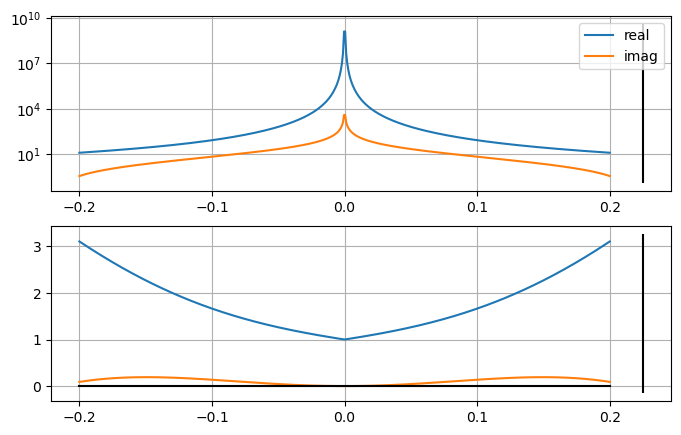

In [157]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5)) 

dipole = fdem.ElectricDipoleWholeSpace(sigma=sig, mu=mur*mu_0, frequency=frequencies[freq_ind], orientation = "z")
total = dipole.current_density(rx_line_locs)

ax[0].semilogy(rx_line_x, np.abs(total[:, 2].real), label=f"real")
ax[0].semilogy(rx_line_x, np.abs(total[:, 2].imag), label=f"imag")

ax[0].grid()
ax[0].legend()

ax[1].plot(rx_line_x, re(np.abs(rx_line_x)))
ax[1].plot(rx_line_x, im(np.abs(rx_line_x)))
ax[1].plot(rx_line_x, np.zeros_like(rx_line_x), color="k")
ax[1].grid()
# ax[1].set_ylim(7*np.r_[-1, 1])

# where is 2 * pi * skin_depth 

for a in ax.flatten(): 
    ylim = a.get_ylim()
    a.vlines(skin_depth(frequencies[freq_ind]), np.min(ylim), np.max(ylim), color="k")
    # a.vlines(im_root.x*np.r_[1, 1], np.min(ylim), np.max(ylim), color="k", lw=1)


In [158]:
def reim_parts(freq, sig=5e6, mur=1):
    omega = 2 * np.pi * freq
    mu = mur*mu_0
    
    alpha = mu * sig * omega
    beta = np.sqrt(alpha/2)

    def real_part(r):
        return (
            np.cos(beta * r) * (beta*r + 1) 
            + np.sin(beta * r) * (alpha*r**2 + beta*r)
        )

    def imag_part(r):
        return (
            np.cos(beta * r) * (alpha*r**2 + beta*r)
            - np.sin(beta * r) * (beta*r + 1) 
        )

    return real_part, imag_part

In [159]:
1/np.sqrt(2)

0.7071067811865475

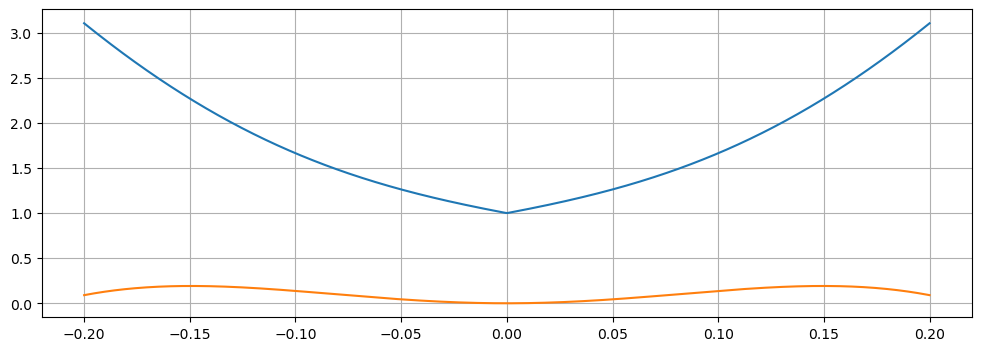

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4)) 

ax.plot(rx_line_x, re(np.abs(rx_line_x)))
ax.plot(rx_line_x, im(np.abs(rx_line_x)))
ax.grid()

In [18]:
import sympy

In [21]:
beta = sympy.symbols("beta")
alpha = -1j*2*beta**2

In [24]:
alpha

-2.0*I*beta**2